In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
# Importing libaries

import opendatasets as od
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
import math
import shutil
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from PIL import Image
import torchvision
from torchvision import models
from torch.autograd import Variable
from torch.optim import Adam
from torch.optim import SGD
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from timeit import default_timer as timer
import torch.optim as optim
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score, accuracy_score
import pandas as pd
import torchvision.models as models
from torchvision.transforms import ToTensor
from torch.optim import Adam
import time

In [3]:
# Downloading Dataset from Kaggle - Kindly upload a kaggle API Key to enable download.

dataset_url = 'https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: usamaran
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered


100%|██████████| 427M/427M [00:04<00:00, 98.6MB/s]


In [5]:
# Removing unwanted file in folder

data_dir = './diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
for filename in os.listdir(data_dir):
    file_path = os.path.join(data_dir, filename)
    if filename.endswith('.pkl'):
        os.remove(file_path)
        print(f'Removed file: {filename}')

print('All desired files removed successfully.')

All desired files removed successfully.


In [6]:
os.listdir(data_dir)

['No_DR', 'Proliferate_DR', 'Severe', 'Moderate', 'Mild']

In [7]:
# Checking number of data available

for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

No_DR : 1805
Proliferate_DR : 295
Severe : 193
Moderate : 999
Mild : 370


In [8]:
# Augmenting dataset to evenly distribute available data

import os
import random
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define the data augmentation transforms
data_transforms = transforms.Compose([
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(0, shear=20, scale=(0.8, 1.2))
])

# Define the path to the original dataset
data_dir = './diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'

# Load the dataset using ImageFolder
dataset = ImageFolder(root=data_dir, transform=data_transforms)

# Define the number of images to sample from each class
num_images = 2000

# Create a dictionary to store the augmented images
augmented_images = {c: [] for c in dataset.classes}

# Iterate over the dataset and apply data augmentation techniques
for image, label in dataset:
    class_label = dataset.classes[label]
    if len(augmented_images[class_label]) < num_images:
        augmented_images[class_label].append(image)

        # If the number of augmented images for a class is less than num_images, augment the image and add it to the dictionary
        if len(augmented_images[class_label]) < num_images:
            augmented_images[class_label].append(data_transforms(image))

# Create a new folder to save the augmented images
new_data_dir = 'new_data_set'
os.makedirs(new_data_dir, exist_ok=True)

# Save the augmented images to the new folder
for c in dataset.classes:
    class_dir = os.path.join(new_data_dir, c)
    os.makedirs(class_dir, exist_ok=True)

    # Shuffle the augmented images for each class
    random.shuffle(augmented_images[c])

    # Save the first num_images augmented images for each class
    for i in range(num_images):
        if i < len(augmented_images[c]):
            image = augmented_images[c][i]
            filename = os.path.join(class_dir, f"{c}_{i}.jpg")
            image.save(filename)

    # If the number of augmented images for a class is still less than num_images,
    # randomly sample and save additional augmented images
    while len(augmented_images[c]) < num_images:
        random_image = random.choice(augmented_images[c])
        filename = os.path.join(class_dir, f"{c}_{len(augmented_images[c])}.jpg")
        random_image.save(filename)
        augmented_images[c].append(random_image)


In [9]:
#Checking the new dataset count

import pandas as pd
# after augmenting the training dataset

data_dir =  '/content/new_data_set'

data = []
for cls in os.listdir(data_dir):
    subdir_path = os.path.join(data_dir, cls)
    file_count = len(os.listdir(subdir_path))
    data.append((cls, file_count))
df = pd.DataFrame(data, columns=['Class', 'Image Count'])
print(df)

dataset = ImageFolder(data_dir)
train_count = len(dataset)
print('Length of the dataset')
print('Length of Training Dataset:',  len(dataset))

            Class  Image Count
0           No_DR         2000
1  Proliferate_DR         2000
2          Severe         2000
3        Moderate         2000
4            Mild         2000
Length of the dataset
Length of Training Dataset: 10000


In [10]:
dataset = ImageFolder(data_dir)

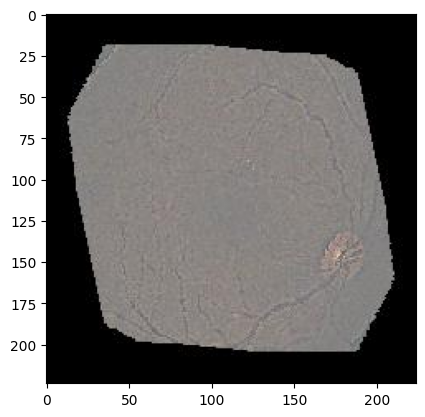

In [11]:
# Viewing one of the images

img, label = dataset[9]

plt.imshow(img)

In [12]:
# Creating function to split and store dataset

num_img = {}
for dir in os.listdir(data_dir):
  num_img[dir] = len(os.listdir(os.path.join(data_dir,dir)))

num_img.items()

def datafolder(folder, split):
    base_path = os.path.dirname(data_dir)
    folder_path = os.path.join(base_path, folder)
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
        for dir in os.listdir(data_dir):
            os.makedirs(os.path.join(folder_path, dir))
            for img in np.random.choice(a=os.listdir(os.path.join(data_dir, dir)), size=(math.floor(split * num_img[dir]) - 5), replace=False):
                O = os.path.join(data_dir, dir, img)
                D = os.path.join(folder_path, dir)
                shutil.copy(O, D)
                os.remove(O)
    else:
        print('the folder exists')

In [13]:
# Splitting the dataset

datafolder('train', 0.6)
datafolder('val', 0.2)
datafolder('test', 0.2)

In [14]:
train_dataset = '/content/train'
val_dataset = '/content/val'
test_dataset = '/content/test'

In [15]:
# Checking amount of dataset in train folder

for cls in os.listdir(train_dataset):
    print(cls, ':', len(os.listdir(train_dataset + '/' + cls)))

train_ds = ImageFolder(train_dataset)
train_count = len(train_ds)
print('Lenght of Training Dataset:',  len(train_ds))

No_DR : 1195
Proliferate_DR : 1195
Severe : 1195
Moderate : 1195
Mild : 1195
Lenght of Training Dataset: 5975


In [16]:
# Checking amount of dataset in validation folder

for cls in os.listdir(val_dataset):
    print(cls, ':', len(os.listdir(val_dataset + '/' + cls)))

valid_ds = ImageFolder(val_dataset)
valid_count = len(valid_ds)
print('Lenght of Validation Dataset:',  len(valid_ds))

No_DR : 395
Proliferate_DR : 395
Severe : 395
Moderate : 395
Mild : 395
Lenght of Validation Dataset: 1975


In [17]:
# Checking amount of dataset in test folder

for cls in os.listdir(test_dataset):
    print(cls, ':', len(os.listdir(test_dataset + '/' + cls)))

test_ds = ImageFolder(test_dataset)
valid_count = len(test_ds)
print('Lenght of Test Dataset:',  len(test_ds))

No_DR : 395
Proliferate_DR : 395
Severe : 395
Moderate : 395
Mild : 395
Lenght of Test Dataset: 1975


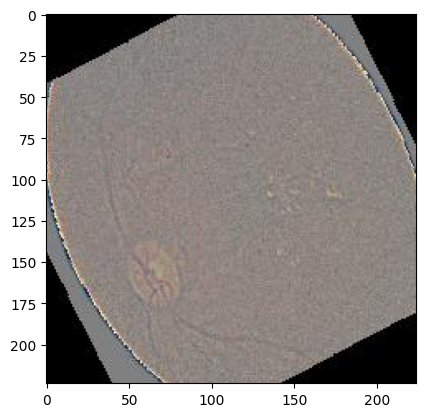

In [18]:
# checking an image in the train dataset

img, label = train_ds[9]
plt.imshow(img)

In [19]:
# Applying some transforms to the dataset to suit the format of the pre-trained model

mean_values = [0.485, 0.456, 0.406]
std_values = [0.229, 0.224, 0.225]


train_ds = ImageFolder(train_dataset, tt.Compose([tt.RandomHorizontalFlip(),
                                                  tt.Resize((224, 224)),
                                                  tt.RandomRotation(45),
                                                  tt.ToTensor(),
                                                  tt.Normalize(mean=mean_values, std=std_values)]))

valid_ds = ImageFolder(val_dataset, tt.Compose([tt.RandomHorizontalFlip(),
                                                tt.Resize((224, 224)),
                                                tt.ToTensor(),
                                                tt.Normalize(mean=mean_values, std=std_values)]))

test_ds = ImageFolder(test_dataset, tt.Compose([tt.Resize((224, 224)),
                                                tt.ToTensor(),
                                                tt.Normalize(mean=mean_values, std=std_values)]))


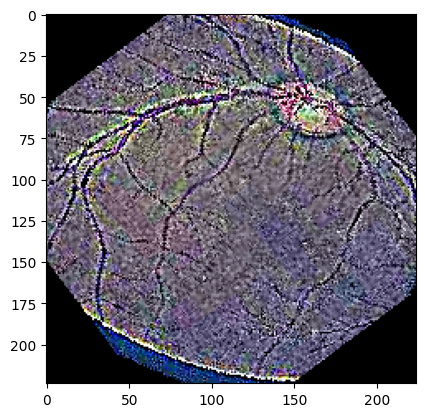

In [20]:
'''image in index 12 after normalization'''

img, label = train_ds[12]
plt.imshow(img.permute((1, 2, 0)))

In [21]:
# Creating a batch size which will be loaded using the 'dataloader' unto the GPU

batch_size = 32

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2)

valid_dl = DataLoader(valid_ds,
                    batch_size,
                    shuffle=True,
                    num_workers=2)

test_dl = DataLoader(test_ds,
                    batch_size,
                    shuffle=True)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


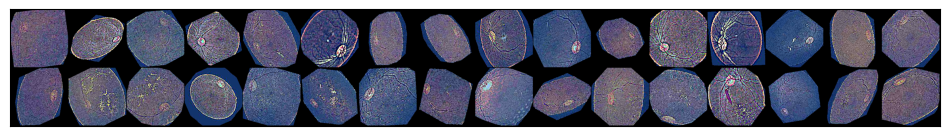

In [22]:
# Displaying a 32-batch dataset from the data from training folder

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_dl)

In [ ]:
# Creating helper functions

"""this block helps choose the available accelerator"""

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# Building the ResNet pre-trained model

class ResNet(nn.Module):
    def __init__(self, model_name, num_classes):
        super(ResNet, self).__init__()
        self.model_name = model_name
        resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])  # Remove last layer (classification layer)
        self.fc = nn.Linear(resnet.fc.in_features, num_classes)

    def forward(self, input):
        features = self.features(input)
        features = features.view(features.size(0), -1)
        output = self.fc(features)
        return output



In [ ]:
# Building the AlexNet pre-trained model

class AlexNet(nn.Module):
    def __init__(self, model_name, num_classes):
        super(AlexNet, self).__init__()
        self.model_name = model_name
        alexnet = models.alexnet(pretrained=True)
        self.features = nn.Sequential(*list(alexnet.features.children()))  # Use only the feature extraction layers

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))  # Adjust the dimensions of the feature maps
        self.fc = nn.Linear(256 * 6 * 6, num_classes)

    def forward(self, input):
        features = self.features(input)
        features = self.avgpool(features)
        features = features.view(features.size(0), -1)
        output = self.fc(features)
        return output


In [ ]:
# Building the VGG pre-trained model

class VGG(nn.Module):
    def __init__(self, model_name, num_classes):
        super(VGG, self).__init__()
        self.model_name = model_name
        vgg = models.vgg16(pretrained=True)
        self.features = nn.Sequential(*list(vgg.features.children()))  # Use only the feature extraction layers

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))  # Adjust the dimensions of the feature maps
        self.fc = nn.Linear(512 * 7 * 7, num_classes)

    def forward(self, input):
        features = self.features(input)
        features = self.avgpool(features)
        features = features.view(features.size(0), -1)
        output = self.fc(features)
        return output


In [ ]:
# Creating function to handle the training

def train_model(model, train_dl, valid_dl, num_epochs):
    train_losses = []
    train_accs = []
    valid_accs = []
    best_val_accuracy = 0.0
    best_model_state = None

    # num_classes = 5
    num_epochs = num_epochs

    # define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    loss_function=nn.CrossEntropyLoss()

    # Start the timer
    start_time = timer()

    model_name = model.model_name  # Get the model name from the ModelBuilder instance

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        train_accuracy = 0.0
        train_loss = 0.0
        train_count = len(train_ds)
        for i, (images, labels) in enumerate(train_dl):
            if torch.cuda.is_available():
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.cpu().data * images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            train_accuracy += int(torch.sum(prediction == labels.data))
        train_accuracy = train_accuracy / train_count
        train_loss = train_loss / train_count

        # Evaluation loop
        model.eval()
        valid_accuracy = 0.0
        valid_count = len(valid_ds)
        for i, (images, labels) in enumerate(valid_dl):
            if torch.cuda.is_available():
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())
            outputs = model(images)
            _, prediction = torch.max(outputs.data, 1)
            valid_accuracy += int(torch.sum(prediction == labels.data))
        valid_accuracy = valid_accuracy / valid_count


        # Append loss and accuracy values to lists
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)
        valid_accs.append(valid_accuracy)

        if valid_accuracy > best_val_accuracy:
          best_val_accuracy = valid_accuracy
          best_model_state = model.state_dict()

        torch.save(best_model_state, f'{model_name}_best_model.pth')

        # Print and plot loss and accuracy values for each epoch
        print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) +
              ' Train Accuracy: ' + str(train_accuracy) +
              ' Validation Accuracy: ' + str(valid_accuracy))


    # end training time
    end_time = timer()
    print()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

    return train_losses, train_accs, valid_accs


In [ ]:
# Function to plot training curve

def plot_curves(train_losses, train_accs, valid_accs, num_epochs):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, valid_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Function to visualize predictions

import warnings

def visualize_predictions(model, data_loader, device, class_names, grid_x=5, grid_y=5):
    num_images = grid_x * grid_y
    plt.figure(figsize=(10, 10))
    model.eval()

    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            if i >= num_images:
                break

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            img = images[0].permute(1, 2, 0).cpu().numpy()

            # Normalize image data
            img = (img - np.min(img)) / (np.max(img) - np.min(img))

            plt.subplot(grid_x, grid_y, i + 1)
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=UserWarning)
                plt.imshow(img)

            if preds[0].item() == labels[0].item():
                xlabel_color = 'green'
                ylabel_color = 'green'
            else:
                xlabel_color = 'red'
                ylabel_color = 'red'

            predicted_class = class_names[preds[0].item()]
            true_class = class_names[labels[0].item()]

            plt.xlabel(predicted_class, color=xlabel_color, fontsize=5)
            plt.ylabel(true_class, color=ylabel_color, fontsize=5)
            plt.xticks(fontsize=5)
            plt.yticks(fontsize=5)
            plt.axis('on')

            if i == num_images - 1:
                break

    plt.tight_layout()
    plt.show()



In [ ]:
# Function to generate confusion matrix

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def generate_confusion_matrix(model, data_loader, device, num_classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    confusion_mat = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    return confusion_mat


In [ ]:
# Function to generate confusion matrix

def calculate_metrics(confusion_mat):
    tp = np.diag(confusion_mat)
    fp = np.sum(confusion_mat, axis=0) - tp
    fn = np.sum(confusion_mat, axis=1) - tp
    tn = np.sum(confusion_mat) - (tp + fp + fn)

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * precision * recall / (precision + recall)

    return accuracy, precision, recall, f1_score


In [ ]:
# Function to display confusion matrix

def display_confusion_matrix(confusion_mat, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_mat, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, str(confusion_mat[i, j]), ha='center', va='center', color='white' if confusion_mat[i, j] > confusion_mat.max() / 2 else 'black')

    plt.tight_layout()
    plt.show()



In [ ]:
# Function to display confusion matrix

def generate_confusion_matrix_with_metrics(model, data_loader, device, num_classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        confusion_mat = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
        accuracy, precision, recall, f1_score = calculate_metrics(confusion_mat)

        print("Confusion Matrix:")
        print(confusion_mat)
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1-Score:", f1_score)


In [ ]:
# Identifying available device (CPU/GPU) and loading data unto it

device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
# variable to insert the number of classes and the number of Epoch to run

num_classes = 5
num_epochs = 25

Epoch: 0 Train Loss: tensor(1.0412) Train Accuracy: 0.5732217573221757 Validation Accuracy: 0.649620253164557
Epoch: 1 Train Loss: tensor(0.7722) Train Accuracy: 0.6964016736401674 Validation Accuracy: 0.7174683544303797
Epoch: 2 Train Loss: tensor(0.6390) Train Accuracy: 0.7563179916317991 Validation Accuracy: 0.7534177215189873
Epoch: 3 Train Loss: tensor(0.5076) Train Accuracy: 0.8097071129707113 Validation Accuracy: 0.810632911392405
Epoch: 4 Train Loss: tensor(0.4263) Train Accuracy: 0.8455230125523012 Validation Accuracy: 0.8217721518987342
Epoch: 5 Train Loss: tensor(0.3874) Train Accuracy: 0.857071129707113 Validation Accuracy: 0.8313924050632912
Epoch: 6 Train Loss: tensor(0.3261) Train Accuracy: 0.8830125523012552 Validation Accuracy: 0.8278481012658228
Epoch: 7 Train Loss: tensor(0.2736) Train Accuracy: 0.9002510460251046 Validation Accuracy: 0.8658227848101265
Epoch: 8 Train Loss: tensor(0.2622) Train Accuracy: 0.9046025104602511 Validation Accuracy: 0.8683544303797468
Epoc

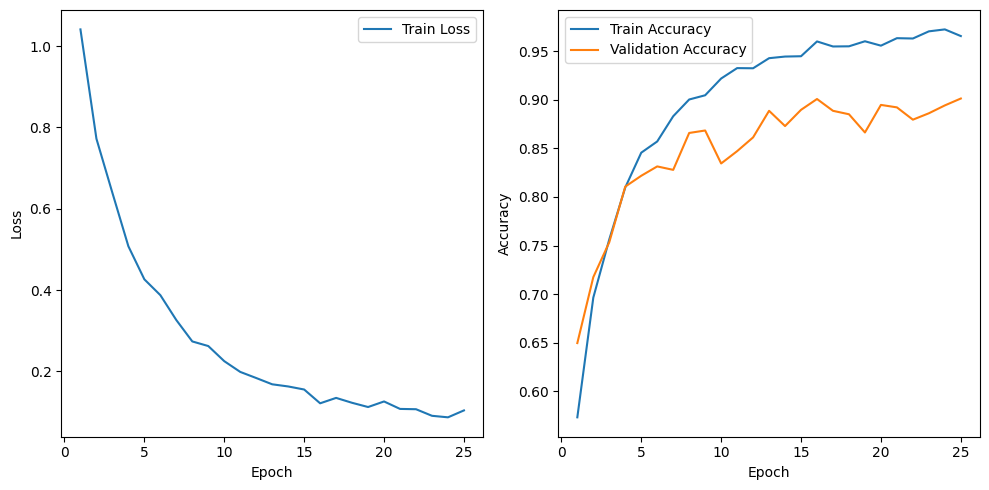

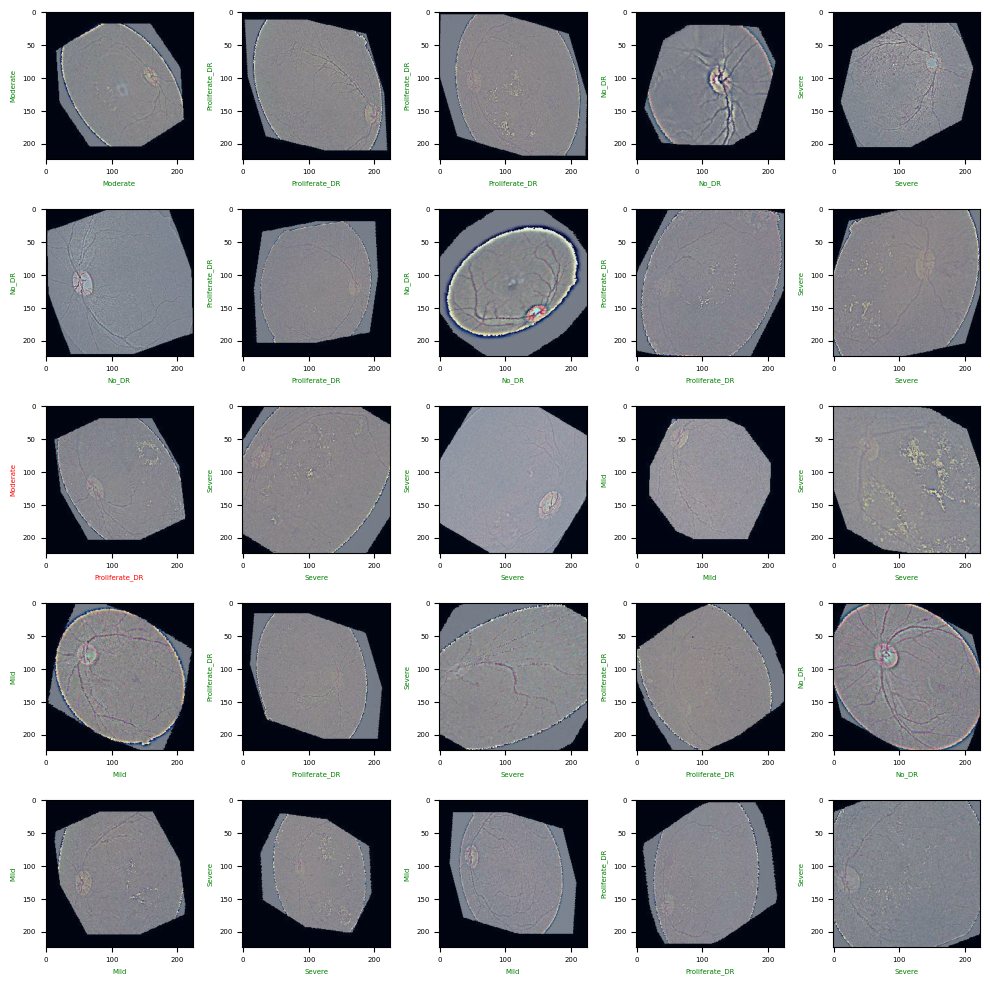

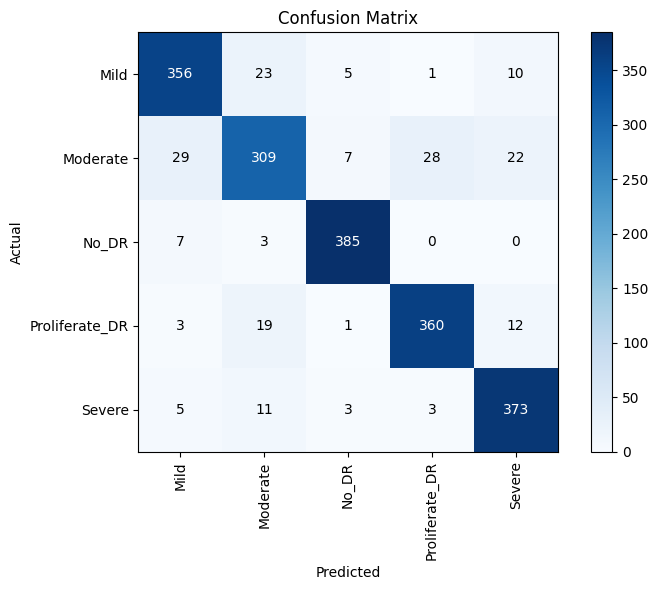



Confusion Matrix:
[[356  23   5   1  10]
 [ 29 309   7  28  22]
 [  7   3 385   0   0]
 [  3  19   1 360  12]
 [  5  11   3   3 373]]
Accuracy: [0.95797468 0.92810127 0.98683544 0.96607595 0.96658228]
Precision: [0.89       0.84657534 0.96009975 0.91836735 0.89448441]
Recall: [0.90126582 0.78227848 0.97468354 0.91139241 0.9443038 ]
F1-Score: [0.89559748 0.81315789 0.96733668 0.91486658 0.91871921]


In [ ]:
# Resnet
model = ResNet('ResNet', num_classes)
model.to(device)


train_losses, train_accs, valid_accs = train_model(model, train_dl, valid_dl, num_epochs)

print()
print()
print()

# plot loss and validation curves
plot_curves(train_losses, train_accs, valid_accs, num_epochs)

# saving the best weights to be applied to the test dataset
best_model_state = torch.load('/content/ResNet_best_model.pth')
model = ResNet('ResNet', num_classes)
model.load_state_dict(best_model_state)
model.to(device)
model.eval()


# Visualize results
visualize_predictions(model, test_dl, device, test_ds.classes)
print()
print()
generate_confusion_matrix(model, test_dl, device, num_classes)
print()
print()
confusion_mat = generate_confusion_matrix(model, test_dl, device, num_classes)
print()
print()
display_confusion_matrix(confusion_mat, test_ds.classes)
print()
print()
generate_confusion_matrix_with_metrics(model, test_dl, device, num_classes)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 157MB/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely l

Epoch: 0 Train Loss: tensor(1.2617) Train Accuracy: 0.4500418410041841 Validation Accuracy: 0.5250632911392406
Epoch: 1 Train Loss: tensor(1.0758) Train Accuracy: 0.5476150627615063 Validation Accuracy: 0.579240506329114
Epoch: 2 Train Loss: tensor(0.9887) Train Accuracy: 0.5914644351464435 Validation Accuracy: 0.5929113924050633
Epoch: 3 Train Loss: tensor(0.9377) Train Accuracy: 0.6219246861924687 Validation Accuracy: 0.610632911392405
Epoch: 4 Train Loss: tensor(0.8705) Train Accuracy: 0.6465271966527196 Validation Accuracy: 0.6475949367088608
Epoch: 5 Train Loss: tensor(0.8430) Train Accuracy: 0.6641004184100419 Validation Accuracy: 0.6744303797468354
Epoch: 6 Train Loss: tensor(0.7826) Train Accuracy: 0.6942259414225942 Validation Accuracy: 0.649620253164557
Epoch: 7 Train Loss: tensor(0.7218) Train Accuracy: 0.7206694560669457 Validation Accuracy: 0.690632911392405
Epoch: 8 Train Loss: tensor(0.6905) Train Accuracy: 0.7348953974895398 Validation Accuracy: 0.7144303797468354
Epoch

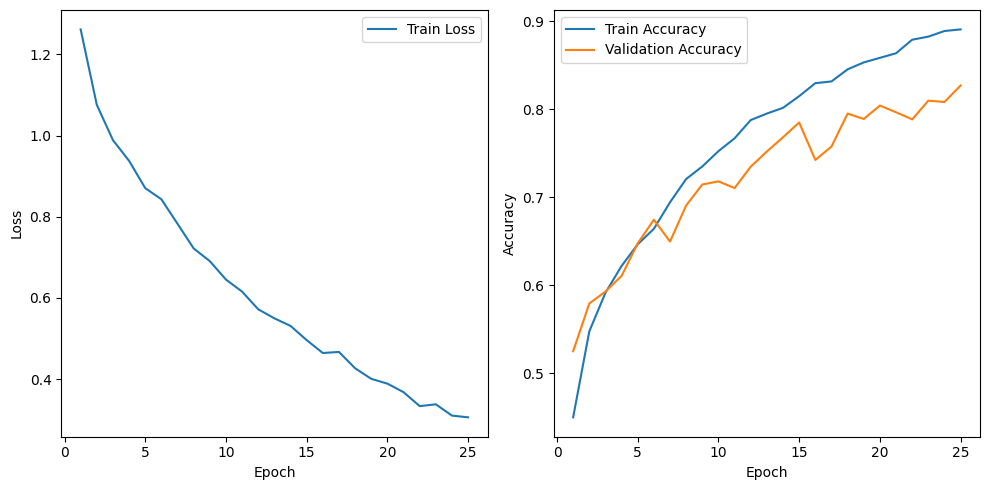

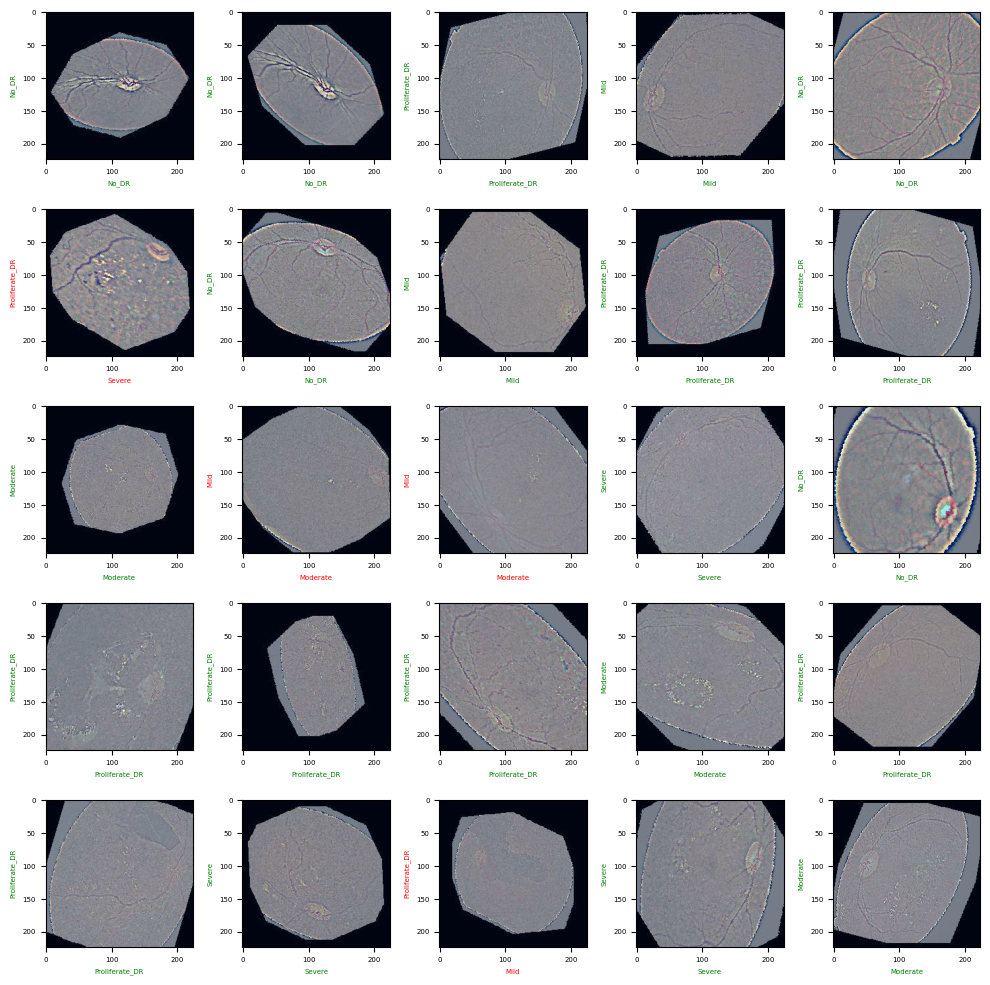

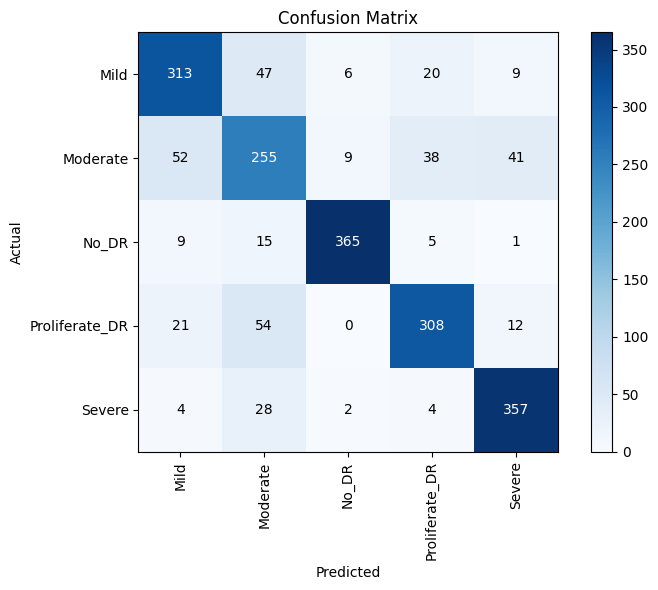



Confusion Matrix:
[[313  47   6  20   9]
 [ 52 255   9  38  41]
 [  9  15 365   5   1]
 [ 21  54   0 308  12]
 [  4  28   2   4 357]]
Accuracy: [0.91493671 0.85620253 0.97620253 0.92202532 0.94886076]
Precision: [0.78446115 0.63909774 0.95549738 0.82133333 0.85      ]
Recall: [0.79240506 0.64556962 0.92405063 0.77974684 0.90379747]
F1-Score: [0.7884131  0.64231738 0.93951094 0.8        0.87607362]


In [ ]:
# AlexNet
model = AlexNet('AlexNet', num_classes)
model.to(device)


train_losses, train_accs, valid_accs = train_model(model, train_dl, valid_dl, num_epochs)

print()
print()
print()

# plot loss and validation curves
plot_curves(train_losses, train_accs, valid_accs, num_epochs)

# saving the best weights to be applied to the test dataset
best_model_state = torch.load('/content/AlexNet_best_model.pth')
model = AlexNet('AlexNet', num_classes)
model.load_state_dict(best_model_state)
model.to(device)
model.eval()


# Visualize results
visualize_predictions(model, test_dl, device, test_ds.classes)
print()
print()
generate_confusion_matrix(model, test_dl, device, num_classes)
print()
print()
confusion_mat = generate_confusion_matrix(model, test_dl, device, num_classes)
print()
print()
display_confusion_matrix(confusion_mat, test_ds.classes)
print()
print()
generate_confusion_matrix_with_metrics(model, test_dl, device, num_classes)


Epoch: 0 Train Loss: tensor(1.2466) Train Accuracy: 0.45573221757322174 Validation Accuracy: 0.5397468354430379
Epoch: 1 Train Loss: tensor(1.0871) Train Accuracy: 0.5310460251046025 Validation Accuracy: 0.5341772151898734
Epoch: 2 Train Loss: tensor(1.0036) Train Accuracy: 0.5794142259414226 Validation Accuracy: 0.620253164556962
Epoch: 3 Train Loss: tensor(0.9036) Train Accuracy: 0.6334728033472803 Validation Accuracy: 0.6435443037974684
Epoch: 4 Train Loss: tensor(0.8535) Train Accuracy: 0.6557322175732218 Validation Accuracy: 0.7078481012658228
Epoch: 5 Train Loss: tensor(0.7793) Train Accuracy: 0.6873640167364017 Validation Accuracy: 0.6713924050632911
Epoch: 6 Train Loss: tensor(0.7362) Train Accuracy: 0.7114644351464435 Validation Accuracy: 0.7367088607594937
Epoch: 7 Train Loss: tensor(0.6686) Train Accuracy: 0.7390794979079498 Validation Accuracy: 0.7372151898734177
Epoch: 8 Train Loss: tensor(0.6057) Train Accuracy: 0.7663598326359833 Validation Accuracy: 0.7574683544303797
E

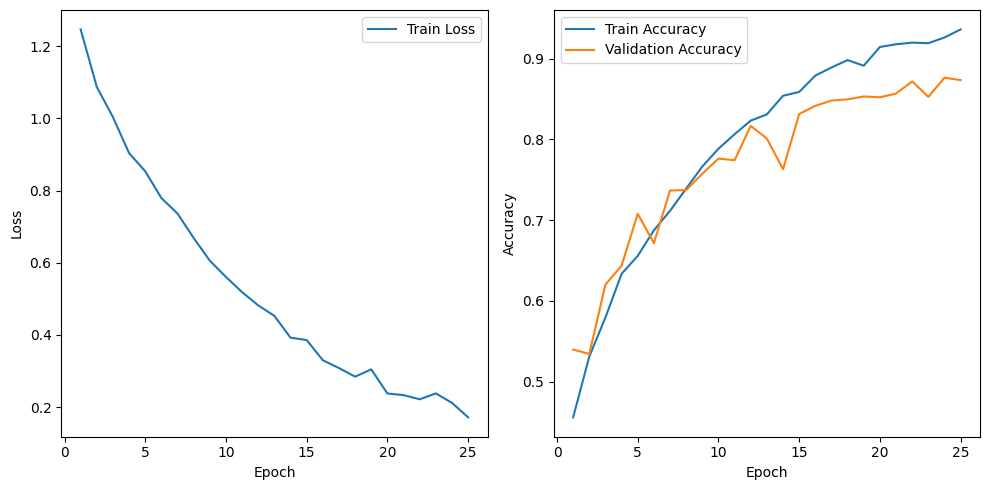

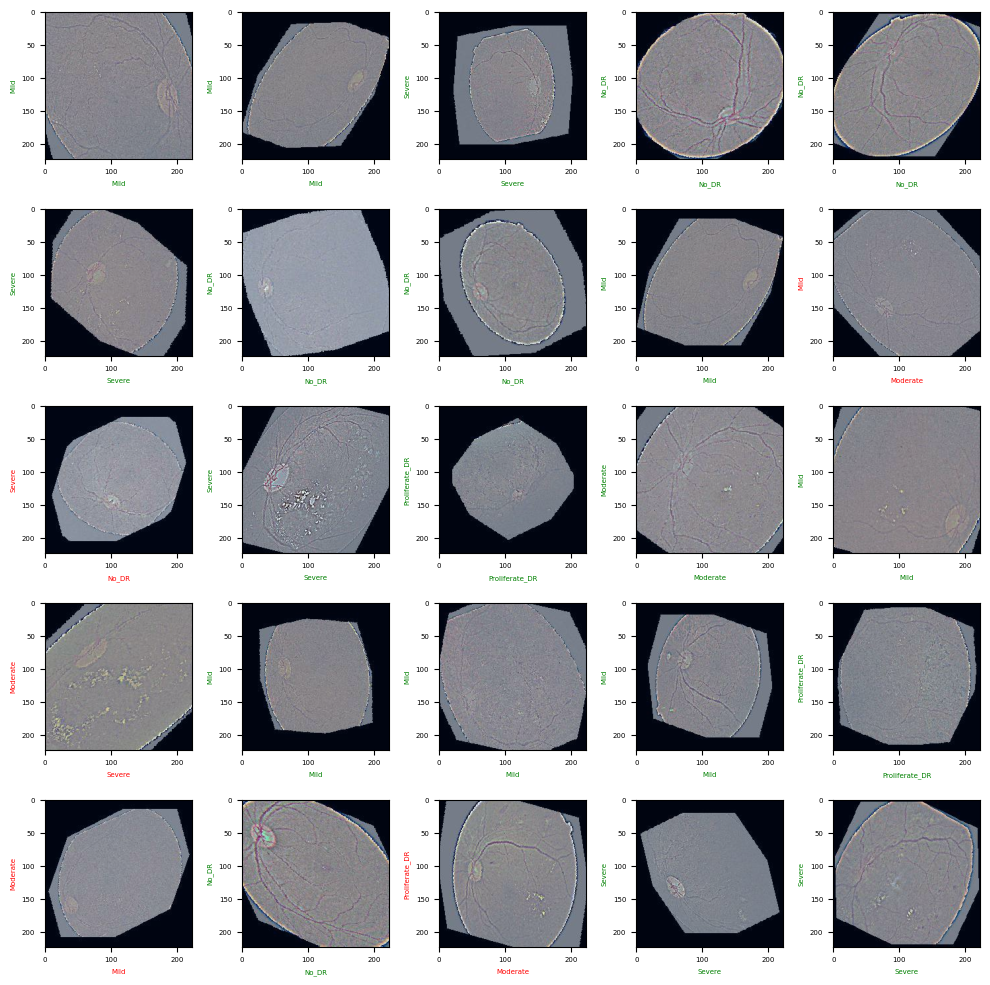

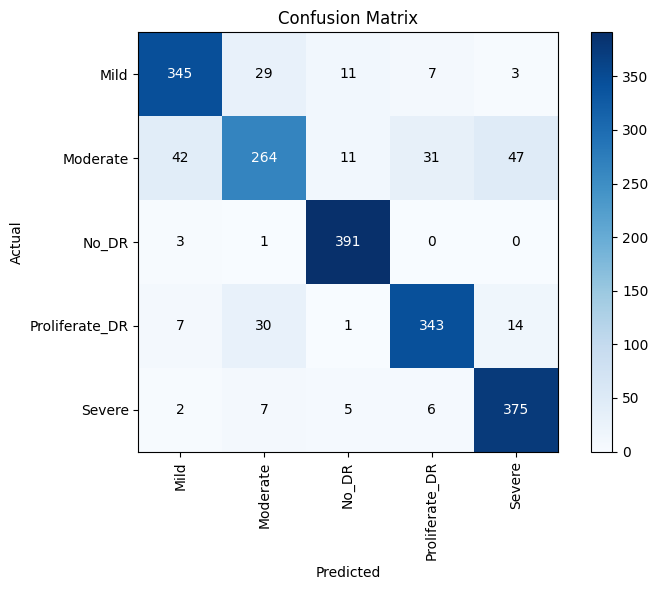



Confusion Matrix:
[[345  29  11   7   3]
 [ 42 264  11  31  47]
 [  3   1 391   0   0]
 [  7  30   1 343  14]
 [  2   7   5   6 375]]
Accuracy: [0.94734177 0.89974684 0.98379747 0.95139241 0.95746835]
Precision: [0.86466165 0.79758308 0.93317422 0.88630491 0.85421412]
Recall: [0.87341772 0.66835443 0.98987342 0.86835443 0.94936709]
F1-Score: [0.86901763 0.72727273 0.96068796 0.87723785 0.89928058]


In [ ]:
# VGG
model = VGG('VGG', num_classes)
model.to(device)


train_losses, train_accs, valid_accs = train_model(model, train_dl, valid_dl, num_epochs)


print()
print()
print()

# plot loss and validation curves
plot_curves(train_losses, train_accs, valid_accs, num_epochs)

# saving the best weights to be applied to the test dataset
best_model_state = torch.load('/content/VGG_best_model.pth')
model = VGG('VGG', num_classes)
model.load_state_dict(best_model_state)
model.to(device)
model.eval()

# Visualize results
visualize_predictions(model, test_dl, device, test_ds.classes)
print()
print()
generate_confusion_matrix(model, test_dl, device, num_classes)
print()
print()
confusion_mat = generate_confusion_matrix(model, test_dl, device, num_classes)
print()
print()
display_confusion_matrix(confusion_mat, test_ds.classes)
print()
print()
generate_confusion_matrix_with_metrics(model, test_dl, device, num_classes)


In [ ]:
import torch.nn as nn

class SequentialVGG(nn.Module):
    def __init__(self, num_classes):
        super(SequentialVGG, self).__init__()
        self.model_name = "SequentialVGG"
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0 Train Loss: tensor(1.5285) Train Accuracy: 0.28234309623430964 Validation Accuracy: 0.379746835443038
Epoch: 1 Train Loss: tensor(1.3652) Train Accuracy: 0.3909623430962343 Validation Accuracy: 0.40810126582278483
Epoch: 2 Train Loss: tensor(1.3043) Train Accuracy: 0.42092050209205023 Validation Accuracy: 0.43949367088607594
Epoch: 3 Train Loss: tensor(1.2547) Train Accuracy: 0.4520502092050209 Validation Accuracy: 0.4789873417721519
Epoch: 4 Train Loss: tensor(1.1923) Train Accuracy: 0.48502092050209206 Validation Accuracy: 0.4769620253164557
Epoch: 5 Train Loss: tensor(1.1409) Train Accuracy: 0.5161506276150628 Validation Accuracy: 0.4956962025316456
Epoch: 6 Train Loss: tensor(1.1049) Train Accuracy: 0.530376569037657 Validation Accuracy: 0.5397468354430379
Epoch: 7 Train Loss: tensor(1.0648) Train Accuracy: 0.55581589958159 Validation Accuracy: 0.5635443037974683
Epoch: 8 Train Loss: tensor(1.0294) Train Accuracy: 0.5663598326359832 Validation Accuracy: 0.5782278481012658


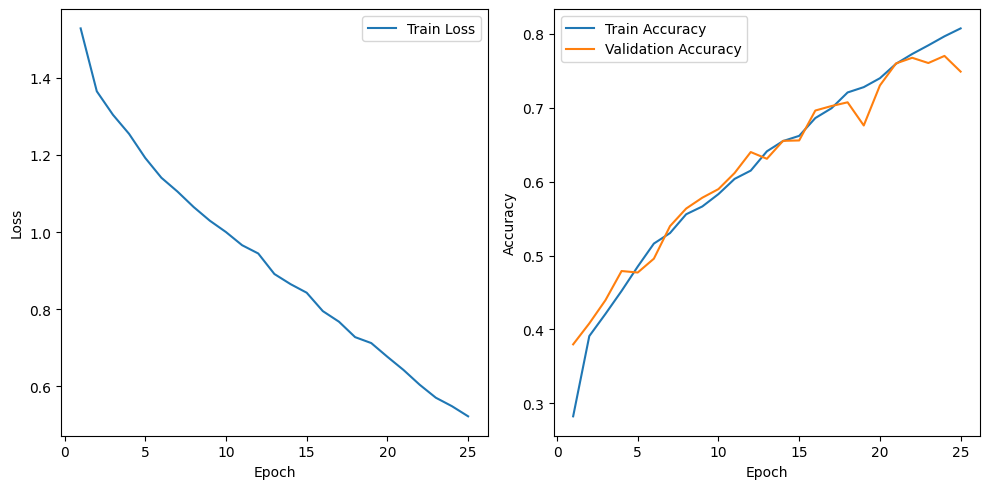

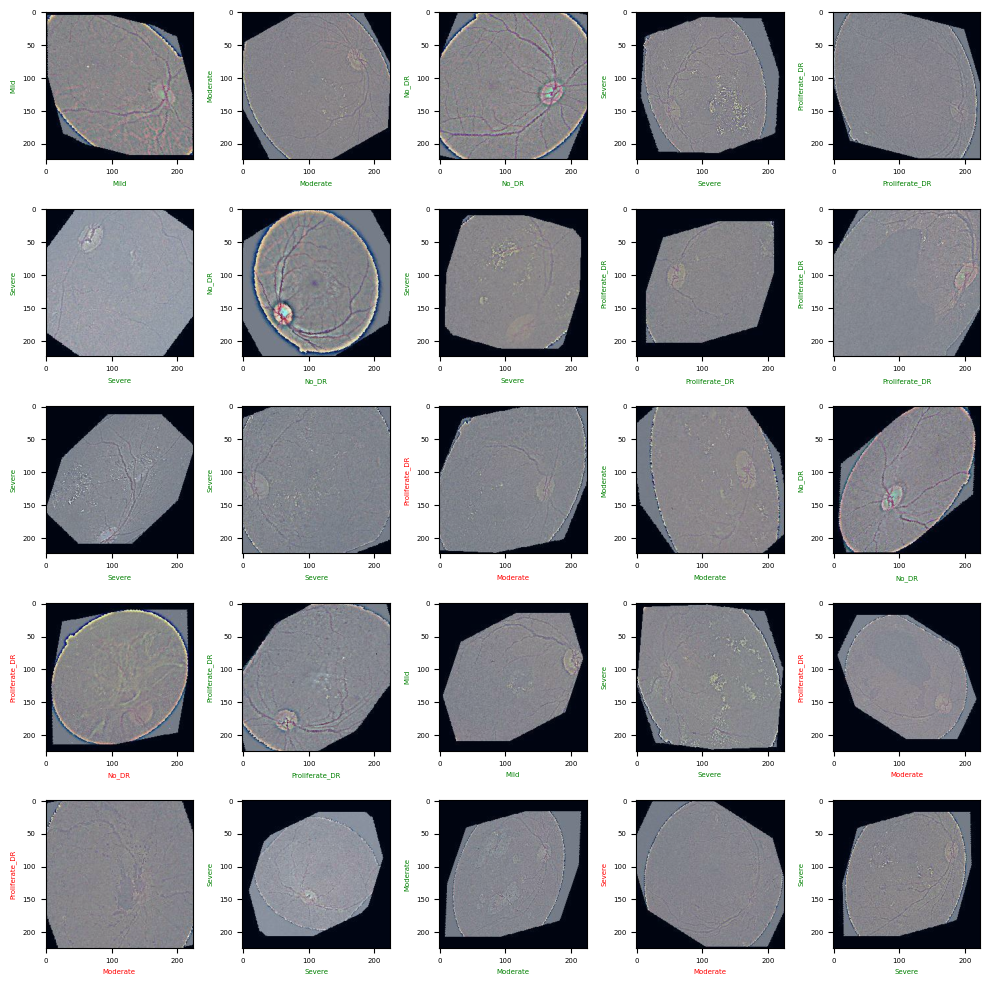

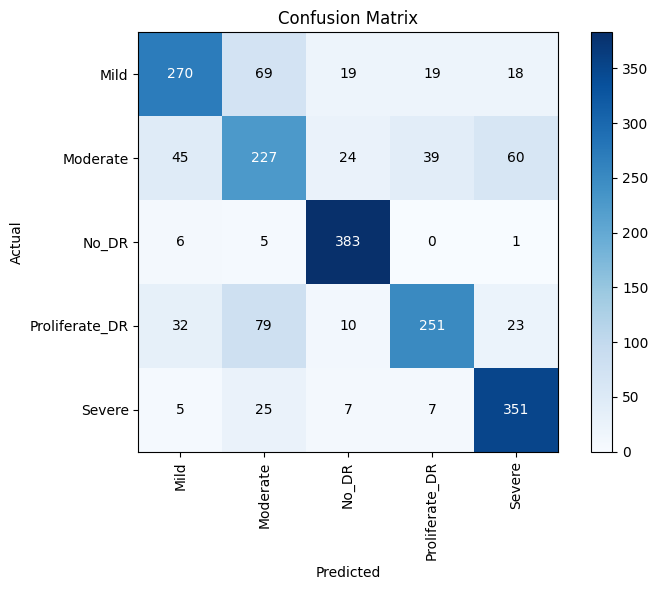



Confusion Matrix:
[[270  69  19  19  18]
 [ 45 227  24  39  60]
 [  6   5 383   0   1]
 [ 32  79  10 251  23]
 [  5  25   7   7 351]]
Accuracy: [0.8921519  0.82481013 0.9635443  0.89417722 0.92607595]
Precision: [0.75418994 0.56049383 0.86455982 0.7943038  0.77483444]
Recall: [0.6835443  0.57468354 0.96962025 0.63544304 0.88860759]
F1-Score: [0.71713147 0.5675     0.91408115 0.70604782 0.82783019]


In [ ]:
# SequentialVGG
model = SequentialVGG(num_classes)
model.to(device)

train_losses, train_accs, valid_accs = train_model(model, train_dl, valid_dl, num_epochs)

print()
print()
print()

# plot loss and validation curves
plot_curves(train_losses, train_accs, valid_accs, num_epochs)

# saving the best weights to be applied to the test dataset
best_model_state = torch.load('/content/SequentialVGG_best_model.pth')
model = SequentialVGG(num_classes)
model.load_state_dict(best_model_state)
model.to(device)
model.eval()

# Visualize results
visualize_predictions(model, test_dl, device, test_ds.classes)
print()
print()
generate_confusion_matrix(model, test_dl, device, num_classes)
print()
print()
confusion_mat = generate_confusion_matrix(model, test_dl, device, num_classes)
print()
print()
display_confusion_matrix(confusion_mat, test_ds.classes)
print()
print()
generate_confusion_matrix_with_metrics(model, test_dl, device, num_classes)


In [ ]:
import torch
from torchvision import transforms
from PIL import Image

# Load the model
model = VGG('VGG', num_classes)
model.load_state_dict(torch.load('/content/VGG_best_model.pth'))
model.to(device)
model.eval()

# Define the transformations for preprocessing the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the input image
image_path = '/content/00cb6555d108.png'
image = Image.open(image_path)
image = transform(image).unsqueeze(0).to(device)

# Make predictions
with torch.no_grad():
    output = model(image)

# Get the predicted class
predicted_class = torch.argmax(output, dim=1).item()

# Display the predicted class
print("Predicted class:", predicted_class)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted class: 2
